# Results

In [8]:
# imports
import os
import yaml
import numpy as np
import pandas as pd
import theano
import lasagne
import loading
from training import *
from network import *
from architectures import *
from scipy.stats import bayes_mvs, entropy, linregress, spearmanr

# aliases
L = lasagne.layers
nl = lasagne.nonlinearities
T = theano.tensor
bmvs = bayes_mvs

## Data Loading

In [9]:
headdir = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games')
paramsdir = os.path.join(headdir, 'Analysis/0_hvh/Params/nnets/temp')
datadir = os.path.join(headdir, 'Data/model input')
resultsdir = os.path.join(headdir, 'Analysis/0_hvh/Loglik/nnets')

data = loading.default_loader(os.path.join(datadir, '1-4 (no computer).csv'))
hvhdata = loading.default_loader(os.path.join(datadir, '0 (with groups).csv'))
df = hvhdata[0]
Xs = np.concatenate(hvhdata[2])
ys = np.concatenate(hvhdata[3])
Ss = np.concatenate(hvhdata[4])

defmod = np.loadtxt(os.path.expanduser('~/Downloads/loglik_hvh_final.txt')).reshape([40, 5])

## Compile Results

In [29]:
def unfreeze(net):
    for layer in L.get_all_layers(net.net):
        for param in layer.params:
            layer.params[param].add('trainable')
    net.params = L.get_all_params(net.net, trainable=True)
    
    return None

def load_arch_specs(archname):
    with open('arch_specs.yaml') as archfile:
        arch = yaml.load(archfile)
    return arch[archname]

def load_pretrain_results(archname, archfunc, idx, net=None):
    specs = load_arch_specs(archname)
    arch = lambda input_var: archfunc(input_var, **specs['kwargs'])
    fname = '{} {} split agg fit exp 1-4.npz'.format(archname, idx)
    resdf = pd.DataFrame(index=np.arange(Xt.shape[0]), columns=[idx])

    if net is None:
        net = Network(arch)
    
    net.load_params(os.path.join(paramsdir, fname))
    res = net.itemized_test_fn(Xt, yt)
    outputs = net.output_fn(Xt)
    resdf[idx] = res
    return resdf, outputs, net

def load_train_results(archname, archfunc, idx, test_idx, net=None):
    group_idx = (test_idx - 1) % 5
    selection = df.loc[df['group']==(group_idx+1)].index.values
    resdf = pd.DataFrame(index=np.arange(Xt.shape[0]), columns=[idx])
    preddf = pd.DataFrame(index=selection, columns=np.arange(36))
    
    specs = load_arch_specs(archname)
    arch = lambda input_var: archfunc(input_var, **specs['kwargs'])
    fname = '{} {} agg fit exp 1-4 {} tune fit exp 0.npz'.format(archname, idx, test_idx)
    
    if net is None:
        net = Network(arch)
    
    net.load_params(os.path.join(paramsdir, fname))
    res = net.itemized_test_fn(Xt[selection, :, :, :], yt[selection])
    outputs = net.output_fn(Xt[selection, :, :, :])
    preddf.loc[selection, :] = outputs
    resdf.loc[selection, idx] = res
    return resdf, preddf, net

In [13]:
archname = 'h4'
archfunc = multiconvX_ws
Xt, yt, _, _, _ = loading.unpack_data(df)

pretrain_nets = []
pretrain_results = []
pretrain_outputs = []

for idx in range(5):
    resdf, outputs, net = load_pretrain_results(archname, archfunc, idx)
    pretrain_nets.append(net)
    pretrain_results.append(resdf)
    pretrain_outputs.append(outputs)

pretrain_results = pd.concat(pretrain_results, axis=1)
pretrain_results.to_csv(os.path.join(resultsdir, 'pretrain {}.csv'.format(archname)))

In [20]:
for i, o in enumerate(pretrain_outputs):
    np.savetxt(os.path.join(resultsdir, 'network_predictions', '{}.csv'.format(i)), o, delimiter=',')

In [5]:
pretrain_results['mean'] = pretrain_results.mean(axis=1)
pretrain_results.pivot_table(index=df['subject'], values='mean').mean()

1.982299856690378

In [30]:
train_nets = []
train_results = []
train_outputs = []

for idx in range(5):
    for test_idx in range(5):
        resdf, outputs, net = load_train_results(archname, archfunc, idx, test_idx)
        train_nets.append(net)
        train_results.append(resdf)
        train_outputs.append(outputs)

train_results = pd.concat(train_results, axis=1, join='inner').stack().unstack()
train_results.to_csv(os.path.join(resultsdir, 'train {}.csv'.format(archname)))

In [34]:
for i in range(5):
    D_ = pd.concat(train_outputs[i:5+i]).sort_index()
    D_.to_csv(os.path.join(resultsdir, 'network_predictions', 'trained {}.csv'.format(i)), index=False, header=False)

In [7]:
train_results['mean'] = train_results.mean(axis=1)
bmvs(train_results.pivot_table(index=df['subject'], values='mean').values)

(Mean(statistic=1.9549269570194059, minmax=(1.8640069212399626, 2.045846992798849)),
 Variance(statistic=0.12277406515959045, minmax=(0.083240882724647955, 0.17678814527682832)),
 Std_dev(statistic=0.34803206050705632, minmax=(0.28851496100661395, 0.4204618238042882)))

# Per pieces

In [38]:
def count_pieces(row):
    bp, wp = row[['bp', 'wp']]
    n_bp = np.array(list(bp)).astype(int).sum()
    n_wp = np.array(list(wp)).astype(int).sum()
    
    return n_bp + n_wp

df['np'] = df.apply(count_pieces, axis=1)

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

% matplotlib inline

In [49]:
train_results.mean()

0    1.935565
1    1.965420
2    1.957499
3    1.982080
4    1.967877
dtype: float64

In [53]:
chancenll = lambda x: -np.log(1/(36-x))

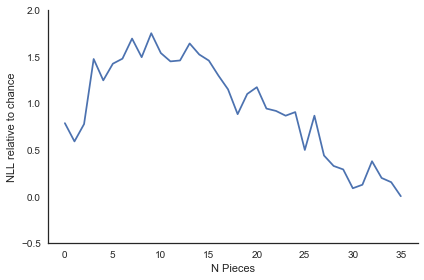

In [65]:
df['chancenll'] = chancenll(df['np'].values)
df['m'] = -(train_results.mean(axis=1).values - df['chancenll'])
np_v_m = df.pivot_table(index='np', values='m')
np_v_m.to_csv(os.path.join(resultsdir, 'num_pieces_vs_nll.csv'), header=False)
plt.plot(np_v_m)

plt.setp(plt.gca(), xlabel='N Pieces', ylabel='NLL relative to chance', ylim=[-.5, 2])

sns.despine()
plt.tight_layout()

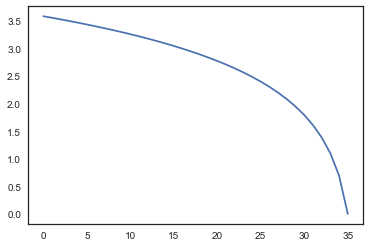

In [63]:
plt.plot(df.pivot_table(index='np', values='chancenll'))

# Response Times

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
plt.rc('text', usetex=True)

%matplotlib inline

In [ ]:
scatterkws = {
    'linestyle': 'none', 
    'marker': 'o', 'markerfacecolor': (.2, .2, .2), 'markeredgecolor': 'black', 
    'alpha': .3
}

histkws = {
    'edgecolor': 'white'
}

In [ ]:
def hicks_entropy(pred):
    H = pred * np.log2(1 / (pred + 1))
    return H.sum(axis=1)

In [ ]:
X, y, S, G, Np = loading.unpack_data(df)
df['mean corrected rt'] = 0
for subject in df['subject'].unique():
    fil = df['subject'] == subject
    df.loc[fil, 'mean corrected rt'] = df.loc[fil, 'rt'] - df.loc[fil, 'rt'].mean()

rt = df['mean corrected rt']

In [ ]:
# compute mean entropy for each test group
E = []
for split_idx in range(25):
    N = train_nets[split_idx]
    locs = np.where(G==(split_idx//5))[0]
    L = N.output_fn(X[locs, :, :, :])
    E.append(hicks_entropy(L))

for g in range(5):
    df.loc[df['group']==(g+1), 'entropy'] = np.array(E[g*5:(g+1)*5]).T.mean(axis=1)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

x = df['entropy']
y = np.log(df['rt']/1000)
axes.plot(x, y, **scatterkws)
lr = linregress(x, y)
pval = lr.pvalue if lr.pvalue >= .001 else .001
axes.text(.05, .05, r"r = {:.2f}, p $<$ {:.3f}".format(lr.rvalue, pval), transform=axes.transAxes, fontsize=14)
plt.setp(axes, xlabel=r"$\textrm{Entropy}$", ylabel=r'$\log{\textrm{Response time (s)}}$', ylim=[-5, 5])

sns.despine()

Hick's law holds (ish).

# Values

In [ ]:
gendata = pd.read_csv(
    os.path.join(headdir, 'Data/1_gen/Clean/_summaries/all_evals_model_input.csv'),
    names=['subject', 'color', 'bp', 'wp', 'zet', 'rt', 'val']
)
gendata['group'] = -1

X, y, S, G, Np = loading.unpack_data(gendata)

In [ ]:
N = train_nets[0]
logistic = lambda x: 1 / (1 + np.exp(-x))
zscore = lambda x: (x - x.mean()) / (x.std() / np.sqrt(x.shape[0]))
Vr = N.value_fn(X)
V = Vr.sum(axis=1)
Vl = 7*logistic(zscore(V))

V2 = np.zeros_like(V)
yz = np.zeros_like(y)
for subject in range(S.max()):
    V2[S==subject] = zscore(V[S==subject])
    yz[S==subject] = zscore(y[S==subject])
    
V2l = 7*logistic(V2)

In [ ]:
Vr = N.value_fn(X) - N.value_fn(X[:, ::-1, :, :])

In [ ]:
plt.hist(V, **histkws)
sns.despine()

In [ ]:
plt.hist(V2, **histkws) #, bins=np.arange(0, 8, .5), **histkws)
sns.despine()

In [ ]:
plt.plot(V, gendata['val'], **scatterkws)
print(linregress(V2, gendata['val']))
sns.despine()

In [ ]:
plt.plot(gendata['val'], gendata['zet'], **scatterkws)
print(linregress(gendata['zet'], gendata['val']))
sns.despine()

In [ ]:
plt.plot(zscore(V), yz, **scatterkws)
print(linregress(zscore(V), yz))
sns.despine()

In [ ]:
gendata['valhat'] = 6*logistic(V2) + 1
gendata['valhat'] = gendata['valhat'].map(int)
gendata['position'] = gendata['bp'] + gendata['wp']
gp = gendata.pivot_table(index='position', columns='zet', values='group', aggfunc=len, fill_value=0)
gvp = gendata.pivot_table(index='position', values='valhat')
gp['valhat'] = gvp.values
gp['valsum'] = gp[list(np.arange(1, 8, 1))].values.argmax(axis=1) + 1
gp.head()

In [ ]:
linregress(gp['valhat'], gp['valsum'])